In [375]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
from random import random

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingClassifier

pd.set_option('display.max_columns', None)

df = pd.read_csv('train.csv').dropna().reset_index(drop=True)
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
178,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
179,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
180,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
181,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
182,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Variable Description¶
* PassengerId : unique id number to each passenger
* Survived: passenger survived (1), died (0)
* Pclass: passenger class
* Name: passenger name
* Sex: gender of passenger
* Age: age of passenger
* SibSp: number of siblings and children
* Parch: number of parents and children
* Ticket: ticket number
* Fare: amount of money that spent on ticket
* Cabin: cabin number
* Embarked: oırt where passenger embarked (C = Cherbourg, Q = Queenstown, S = Couthampton)

### pre-processing

In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    int64  
 1   Survived     183 non-null    int64  
 2   Pclass       183 non-null    int64  
 3   Name         183 non-null    object 
 4   Sex          183 non-null    object 
 5   Age          183 non-null    float64
 6   SibSp        183 non-null    int64  
 7   Parch        183 non-null    int64  
 8   Ticket       183 non-null    object 
 9   Fare         183 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     183 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 17.3+ KB


In [377]:
df['Sex'] = [1 if item=='male' else 0 for item in df.Sex]
df[df.Age.isna()] = np.round(np.mean(df.Age),1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,38.0,1.0,0.0,PC 17599,71.2833,C85,C
1,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,35.0,1.0,0.0,113803,53.1000,C123,S
2,7.0,0.0,1.0,"McCarthy, Mr. Timothy J",1.0,54.0,0.0,0.0,17463,51.8625,E46,S
3,11.0,1.0,3.0,"Sandstrom, Miss. Marguerite Rut",0.0,4.0,1.0,1.0,PP 9549,16.7000,G6,S
4,12.0,1.0,1.0,"Bonnell, Miss. Elizabeth",0.0,58.0,0.0,0.0,113783,26.5500,C103,S


In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    float64
 1   Survived     183 non-null    float64
 2   Pclass       183 non-null    float64
 3   Name         183 non-null    object 
 4   Sex          183 non-null    float64
 5   Age          183 non-null    float64
 6   SibSp        183 non-null    float64
 7   Parch        183 non-null    float64
 8   Ticket       183 non-null    object 
 9   Fare         183 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     183 non-null    object 
dtypes: float64(8), object(4)
memory usage: 17.3+ KB


### feature engineering

In [379]:
df['Deck'] = [item.split(' ')[0][:1] if type(item) == str else None for item in df.Cabin]
df['Num'] = pd.to_numeric([item.split(' ')[0][1:] if type(item) == str else None for item in df.Cabin])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Num
0,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,38.0,1.0,0.0,PC 17599,71.2833,C85,C,C,85.0
1,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,35.0,1.0,0.0,113803,53.1000,C123,S,C,123.0
2,7.0,0.0,1.0,"McCarthy, Mr. Timothy J",1.0,54.0,0.0,0.0,17463,51.8625,E46,S,E,46.0
3,11.0,1.0,3.0,"Sandstrom, Miss. Marguerite Rut",0.0,4.0,1.0,1.0,PP 9549,16.7000,G6,S,G,6.0
4,12.0,1.0,1.0,"Bonnell, Miss. Elizabeth",0.0,58.0,0.0,0.0,113783,26.5500,C103,S,C,103.0


<AxesSubplot:xlabel='Deck', ylabel='count'>

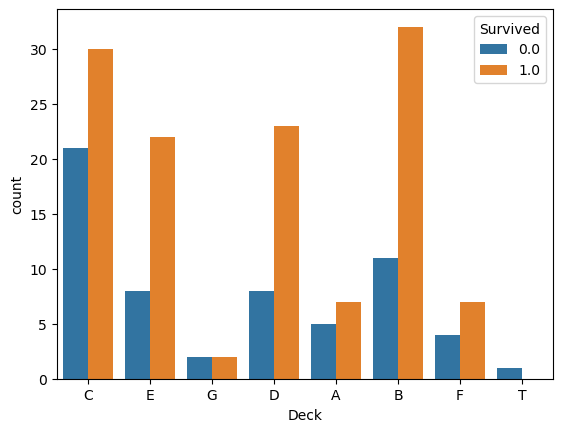

In [380]:
sns.countplot(data=df,x='Deck',hue='Survived')

In [381]:
df['deck_apr_perc'] = [np.round(len(df[df.Deck==item])/len(df),2) for item in df.Deck]
df['deck_survival_rate'] = [np.round(len(df[(df.Deck==item)&(df.Survived==1)])/len(df),2) for item in df.Deck]
df[['Deck','deck_apr_perc','deck_survival_rate']].head()

,Deck,deck_apr_perc,deck_survival_rate
0,C,0.28,0.16
1,C,0.28,0.16
2,E,0.16,0.12
3,G,0.02,0.01
4,C,0.28,0.16


In [382]:
df['num_apr_perc'] = [np.round(len(df[df.Num==item])/len(df),2) for item in df.Num]
df['num_survival_rate'] = [np.round(len(df[(df.Num==item)&(df.Survived==1)])/len(df),2) for item in df.Num]
df[['Num','num_apr_perc','num_survival_rate']].head()

,Num,num_apr_perc,num_survival_rate
0,85.0,0.01,0.01
1,123.0,0.01,0.01
2,46.0,0.02,0.00
3,6.0,0.03,0.02
4,103.0,0.01,0.01


In [383]:
# Feature engineering - apearance percentage & survival rate for each title
df['title'] = None
df.title = [name[name.find(',')+1:name.find('.')] for name in df.Name]
title_dict = df[['title','Survived']].groupby('title').count().sort_values(by='Survived')['Survived'].to_dict()
df['title_apr_perc'] = [title_dict[df.loc[i,'title']]/len(df) for i in df.index]
df['title_survival_rate'] = [len(df[(df.title==df.loc[i,'title'])&(df.Survived==1)])/len(df[df.title==df.loc[i,'title']]) for i in df.index]
df[['title','title_apr_perc','title_survival_rate']]

,title,title_apr_perc,title_survival_rate
0,Mrs,0.207650,0.921053
1,Mrs,0.207650,0.921053
2,Mr,0.442623,0.370370
3,Miss,0.240437,0.931818
4,Miss,0.240437,0.931818
...,...,...,...
178,Mrs,0.207650,0.921053
179,Mr,0.442623,0.370370
180,Mrs,0.207650,0.921053
181,Miss,0.240437,0.931818


In [384]:
df['emb_apr_perc'] = [np.round(len(df[df.Embarked==item])/len(df),2) for item in df.Embarked]
df['emb_survival_rate'] = [np.round(len(df[(df.Embarked==item)&(df.Survived==1)])/len(df),2) for item in df.Embarked]
df[['Embarked','emb_apr_perc','emb_survival_rate']].head()

,Embarked,emb_apr_perc,emb_survival_rate
0,C,0.36,0.26
1,S,0.63,0.40
2,S,0.63,0.40
3,S,0.63,0.40
4,S,0.63,0.40


In [385]:
df['sib_apr_perc'] = [np.round(len(df[df.SibSp==item])/len(df),2) for item in df.SibSp]
df['sib_survival_rate'] = [np.round(len(df[(df.SibSp==item)&(df.Survived==1)])/len(df),2) for item in df.SibSp]
df[['SibSp','sib_apr_perc','sib_survival_rate']].head()

,SibSp,sib_apr_perc,sib_survival_rate
0,1.0,0.35,0.26
1,1.0,0.35,0.26
2,0.0,0.60,0.38
3,1.0,0.35,0.26
4,0.0,0.60,0.38


In [386]:
df['parch_apr_perc'] = [np.round(len(df[df.Parch==item])/len(df),2) for item in df.Parch]
df['parch_survival_rate'] = [np.round(len(df[(df.Parch==item)&(df.Survived==1)])/len(df),2) for item in df.Parch]
df[['Parch','parch_apr_perc','parch_survival_rate']].head()

,Parch,parch_apr_perc,parch_survival_rate
0,0.0,0.67,0.44
1,0.0,0.67,0.44
2,0.0,0.67,0.44
3,1.0,0.20,0.14
4,0.0,0.67,0.44


In [387]:
# mark outliers:
df['outlier'] = False
for col in ['Age','Fare']:
    mean = df[col].mean()
    std = df[col].std()
    df.loc[(df[col] < mean - 3*std)|(df[col] > mean + 3*std),'outlier'] = True

df.outlier.value_counts()

#df = df[df.outlier==False].reset_index(drop=True)

False    181
True       2
Name: outlier, dtype: int64

### Classification model

In [388]:
# model parameters
y = 'Survived'
#X = [col for col in df.columns if col not in ['PassengerId','Survived','Name','Ticket','Cabin','Parch','SibSp']]
X = ['Sex'] + [item for item in df.columns if 'survival_rate' in item] + [item for item in df.columns if 'apr_perc' in item]
df = df[X + [y]]

TEST_AMOUNT = 0.3
EXCLUDE_OUTLIERS = True
print(f'X:{X}\ny:{y}\nTest set:{TEST_AMOUNT}\nTrain set:{1-TEST_AMOUNT}\nExclude Outliers:{EXCLUDE_OUTLIERS}')

X:['Sex', 'deck_survival_rate', 'num_survival_rate', 'title_survival_rate', 'emb_survival_rate', 'sib_survival_rate', 'parch_survival_rate', 'deck_apr_perc', 'num_apr_perc', 'title_apr_perc', 'emb_apr_perc', 'sib_apr_perc', 'parch_apr_perc']
y:Survived
Test set:0.3
Train set:0.7
Exclude Outliers:True


In [389]:
# test train classification
df['set'] = None
df['set'] = ['test' if random() < TEST_AMOUNT else 'train' for item in df.set]
df.set.value_counts()

train    123
test      60
Name: set, dtype: int64

In [390]:
# fit a voting classifier
X_train = df[df['set'] == 'train'][X]
y_train = np.ravel(np.array(df[df['set'] == 'train'][y]).reshape(-1,1))

rf = RandomForestClassifier(random_state=42)

voting_classifier = VotingClassifier(
    estimators=[('rf',RandomForestClassifier(random_state=42)),
                ('xgb',XGBClassifier(random_state=42)),
                ('lr',LogisticRegression(random_state=42)),
                ('svm',SVC(probability=True, random_state=42)), 
                ('knn',KNeighborsClassifier()), 
                ('dt',DecisionTreeClassifier(random_state=42))],
    voting='soft'  # 'soft' for weighted voting based on probabilities, 'hard' for majority voting
)

rf.fit(X=X_train,y=y_train)
voting_classifier.fit(X=X_train,y=y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_...
                                            min_child_weight=None, missing=nan,
                                            monoton

In [391]:
# profile training data:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sex,183.0,0.519126,0.501005,0.000000,0.00000,1.000000,1.000000,1.000000
deck_survival_rate,183.0,0.131475,0.045579,0.000000,0.12000,0.160000,0.160000,0.170000
num_survival_rate,183.0,0.012186,0.007819,0.000000,0.01000,0.010000,0.020000,0.030000
title_survival_rate,183.0,0.672131,0.284332,0.000000,0.37037,0.921053,0.931818,1.000000
emb_survival_rate,183.0,0.346011,0.075767,0.010000,0.26000,0.400000,0.400000,0.400000
sib_survival_rate,183.0,0.320492,0.088307,0.010000,0.26000,0.380000,0.380000,0.380000
parch_survival_rate,183.0,0.332951,0.152705,0.000000,0.14000,0.440000,0.440000,0.440000
deck_apr_perc,183.0,0.195792,0.074931,0.010000,0.16000,0.230000,0.280000,0.280000
num_apr_perc,183.0,0.016721,0.008397,0.000000,0.01000,0.020000,0.020000,0.030000
title_apr_perc,183.0,0.298994,0.142645,0.005464,0.20765,0.240437,0.442623,0.442623


In [392]:
K_FOLD = 5
acc_values = []
for fold in range(1,K_FOLD+1):
    
    df['set'] = ['test' if random() < TEST_AMOUNT else 'train' for item in df.set]
    #print(f'{df.set.value_counts()}')
    
    X_train = df[df['set'] == 'train'][X]
    y_train = np.ravel(np.array(df[df['set'] == 'train'][y]).reshape(-1,1))
    voting_classifier.fit(X=X_train,y=y_train)
    df[f'{y}_pred_fold{fold}'] = voting_classifier.predict(df[X])
    df[f'{y}_proba_fold{fold}'] = [np.round(max(item),3) for item in voting_classifier.predict_proba(df[X])]

    d = df[df.set=='test']
    acc = np.round(len(d[d[f"{y}_pred_fold{fold}"]==d[y]])/(len(d)),3)
    acc_values.append(acc)
    print(f'Fold_{fold}; Accuracy: {acc}')

print(f'\nMean folds accuracy: {np.round(np.mean(acc_values),3)}')
df.head() 

Fold_1; Accuracy: 0.796
Fold_2; Accuracy: 0.818
Fold_3; Accuracy: 0.814
Fold_4; Accuracy: 0.863
Fold_5; Accuracy: 0.884

Mean folds accuracy: 0.835


,Sex,deck_survival_rate,num_survival_rate,title_survival_rate,emb_survival_rate,sib_survival_rate,parch_survival_rate,deck_apr_perc,num_apr_perc,title_apr_perc,emb_apr_perc,sib_apr_perc,parch_apr_perc,Survived,set,Survived_pred_fold1,Survived_proba_fold1,Survived_pred_fold2,Survived_proba_fold2,Survived_pred_fold3,Survived_proba_fold3,Survived_pred_fold4,Survived_proba_fold4,Survived_pred_fold5,Survived_proba_fold5
0,0.0,0.16,0.01,0.921053,0.26,0.26,0.44,0.28,0.01,0.207650,0.36,0.35,0.67,1.0,train,1.0,0.970,1.0,0.959,1.0,0.967,1.0,0.970,1.0,0.969
1,0.0,0.16,0.01,0.921053,0.40,0.26,0.44,0.28,0.01,0.207650,0.63,0.35,0.67,1.0,train,1.0,0.970,1.0,0.954,1.0,0.961,1.0,0.969,1.0,0.967
2,1.0,0.12,0.00,0.370370,0.40,0.38,0.44,0.16,0.02,0.442623,0.63,0.60,0.67,0.0,train,0.0,0.765,0.0,0.697,0.0,0.767,0.0,0.751,0.0,0.790
3,0.0,0.01,0.02,0.931818,0.40,0.26,0.14,0.02,0.03,0.240437,0.63,0.35,0.20,1.0,train,1.0,0.966,1.0,0.793,1.0,0.807,1.0,0.786,1.0,0.902
4,0.0,0.16,0.01,0.931818,0.40,0.38,0.44,0.28,0.01,0.240437,0.63,0.60,0.67,1.0,train,1.0,0.970,1.0,0.954,1.0,0.958,1.0,0.970,1.0,0.967


In [393]:
dict(zip(rf.feature_names_in_,rf.feature_importances_))

{'Sex': 0.10506076954492408,
 'deck_survival_rate': 0.07171534467393267,
 'num_survival_rate': 0.20922732126928342,
 'title_survival_rate': 0.15238879373497055,
 'emb_survival_rate': 0.024309069947839403,
 'sib_survival_rate': 0.02667560169101177,
 'parch_survival_rate': 0.03145058418192202,
 'deck_apr_perc': 0.09200549584614265,
 'num_apr_perc': 0.09942452126802254,
 'title_apr_perc': 0.10366227583033455,
 'emb_apr_perc': 0.02461877245520266,
 'sib_apr_perc': 0.027977704866979588,
 'parch_apr_perc': 0.0314837446894341}